# Notebook to visualize database statistics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlite3
import string
import warnings
warnings.filterwarnings("ignore")

In [2]:
def set_publication_style(
    width_cm=6,
    height_cm=4,
    font_size=8,
    font_family="Arial"):
    """
    Configure matplotlib for publication-ready figures.

    Parameters
    ----------
    width_cm : float
        Figure width in centimeters.
    height_cm : float
        Figure height in centimeters.
    font_size : int
        Base font size in points.
    font_family : str
        Font family to use (e.g. 'Arial', 'Liberation Sans').

    Notes
    -----
    - SVG text remains editable
    - Avoid mathtext/LaTeX if editable text is required
    """

    import matplotlib as mpl

    cm_to_inch = 1 / 2.54

    mpl.rcParams.update({
        # --- SVG / text handling ---
        "svg.fonttype": "none",

        # --- Font ---
        "font.family": font_family,
        "font.size": font_size,

        # --- Axes ---
        "axes.titlesize": font_size,
        "axes.labelsize": font_size,

        # --- Ticks ---
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,

        # --- Legend ---
        "legend.fontsize": font_size,

        # --- Figure size ---
        "figure.figsize": (
            width_cm * cm_to_inch,
            height_cm * cm_to_inch
        )
    })


In [3]:
set_publication_style(
    width_cm=6,
    height_cm=4,
    font_size=10,
    font_family="Arial"
)


## Dataset overview

In [4]:
db_path = "../../PhageExpressionAtlas/instance/db.sqlite3"

def get_table(db: str, table: str):
    """
    db: path to SQLite db
    table_type: which table to extract from the database
    """

    # Connect to the database
    connection = sqlite3.connect(db)

    # ---------------------------------------------------------------------
    # 1) GET DATASETS BY:
    #    - matching normalization
    #    - matching dataset names from dataset_list
    # ---------------------------------------------------------------------

    dataset_query = f"""
        SELECT *
        FROM {table}
    """

    df = pd.read_sql_query(dataset_query, connection)

    # ---------------------------------------------------------------------
    # 2) GET HOST & PHAGE METADATA FOR MERGING
    # ---------------------------------------------------------------------
    host_ids = [int(id) for id in list(df["host_id"].unique())]
    phage_ids = [int(id) for id in list(df["phage_id"].unique())]

    host_placeholders = ",".join("?" * len(host_ids))

    # --- Host metadata ---
    host_query = (
        f'SELECT * '
        f'FROM host WHERE id IN ({host_placeholders})'
    )
    host_info = pd.read_sql_query(host_query, connection, params=host_ids)

    phage_placeholders = ",".join("?" * len(phage_ids))

    # --- Phage metadata ---
    phage_query = (
        f"SELECT * "
        f"FROM phage WHERE id IN ({phage_placeholders})"
    )
    phage_info = pd.read_sql_query(phage_query, connection, params=phage_ids)

    # ---------------------------------------------------------------------
    # 3) MERGE METADATA INTO DATASET TABLE
    # ---------------------------------------------------------------------
    merged = df.merge(host_info, left_on="host_id", right_on="id", how="left", suffixes=("", "_host"))
    merged = merged.merge(phage_info, left_on="phage_id", right_on="id", how="left", suffixes=("", "_phage"))

    # Optional: return merged dataframe + expression dataframe
    return merged

dataset_table = get_table(db_path, 'dataset')
dataset_table = dataset_table.loc[dataset_table['normalization'] == "TPM", ]
dataset_table

,id,phage_id,host_id,matrix_data,normalization,name,journal,year,firstauthor,pubmedID,...,id_host,name_host,group,description_host,ncbi_id,id_phage,name_phage,description_phage,ncbi_id_phage,phage_type
1,2,1,1,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Wolfram-Schauerte_2022,Viruses,2022,Wolfram-Schauerte,36423111,...,1,E. coli B strain,Escherichia coli,E. coli K12 MG1655 reference,U00096.3,1,T4 phage,Bacteriophage T4,NC_000866.4,virulent
6,7,1,2,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Guegler_2021_T4_minus_toxIN,Molecular Cell,2021,Guegler,33838104,...,2,E. coli K 12 pBR322 empty,Escherichia coli,E. coli K12 MG1655 without toxIN expression,U00096.3,1,T4 phage,Bacteriophage T4,NC_000866.4,virulent
11,12,1,3,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Guegler_2021_T4_plus_toxIN,Molecular Cell,2021,Guegler,33838104,...,3,E. coli K 12 pBR322-toxIN,Escherichia coli,E. coli K12 MG1655 expressing toxIN,U00096.3,1,T4 phage,Bacteriophage T4,NC_000866.4,virulent
16,17,2,2,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Guegler_2021_T7_minus_toxIN,Molecular Cell,2021,Guegler,33838104,...,2,E. coli K 12 pBR322 empty,Escherichia coli,E. coli K12 MG1655 without toxIN expression,U00096.3,2,T7 phage,Bacteriophage T7,NC_001604.1,virulent
21,22,2,3,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Guegler_2021_T7_plus_toxIN,Molecular Cell,2021,Guegler,33838104,...,3,E. coli K 12 pBR322-toxIN,Escherichia coli,E. coli K12 MG1655 expressing toxIN,U00096.3,2,T7 phage,Bacteriophage T7,NC_001604.1,virulent
26,27,3,4,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Finstrlova_2022_Newman,Microbiology Spectrum,2022,Finstrlova,3545752,...,4,S. aureus strain Newman,Staphylococcus aureus,Staphylococcus aureus strain Newman,NC_009641.1,3,Kayvirus phage K,Staphylococcus virus K,NC_005880.2,virulent
31,32,3,5,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Finstrlova_2022_SH1000,Microbiology Spectrum,2022,Finstrlova,3545752,...,5,S. aureus SH1000,Staphylococcus aureus,Staphylococcus aureus strain SH1000,NZ_CP059180.1,3,Kayvirus phage K,Staphylococcus virus K,NC_005880.2,virulent
36,37,4,6,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Kuptsov_2022,Viruses,2022,Kuptsov,35336974,...,6,S. aureus strain SA515,Staphylococcus aureus,Staphylococcus aureus strain SA515,GCA_022352045.1,4,vB_SauM-515A1 kayvirus,Staphylococcus phage vB_SauM-515A1,MN047438.1,virulent
41,42,5,7,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Leskinen_2016,Viruses,2016,Leskinen,27110815,...,7,Y. enterocolitica O:3,Yersinia enterolitica,Yersinia enterocolitica O:3,NC_017564.1 + NC_017565.1,5,PhiR1-37,Yersinia phage phiR1-37,AJ972879.2,virulent
46,47,6,8,b'\x80\x04\x95\x13\x01\x00\x00\x00\x00\x00\x00...,TPM,Brandão_2021_LB,RNA Biology,2021,Brandão,33448239,...,8,P. aeruginosa PAO1,Pseudomonas aeruginosa,Pseudomonas aeruginosa PAO1,NC_002516.2,6,LUZ19,Pseudomonas phage LUZ19,NC_010326.1,virulent


In [5]:
dataset_table.shape

(42, 23)

### Plot bar chart of host groups among datasets

In [6]:
df_plot = dataset_table.groupby("group").count()[["id", "name_host"]]
df_plot.columns = ["count", "name_host"]
df_plot["host"] = df_plot.index.tolist()
df_plot.sort_values("count", axis=0, ascending=False, inplace=True)
df_plot

,count,name_host,host
group,,,
Pseudomonas aeruginosa,14,14,Pseudomonas aeruginosa
Staphylococcus aureus,6,6,Staphylococcus aureus
Escherichia coli,5,5,Escherichia coli
Synechococcus species,5,5,Synechococcus species
Vibrio Cholerae,3,3,Vibrio Cholerae
Acinetobacter baumannii,2,2,Acinetobacter baumannii
Staphylococcus epidermidis,2,2,Staphylococcus epidermidis
Caulobacter crescentus,1,1,Caulobacter crescentus
Clostridiodes difficile,1,1,Clostridiodes difficile


In [7]:
host_order = df_plot.index.to_list()

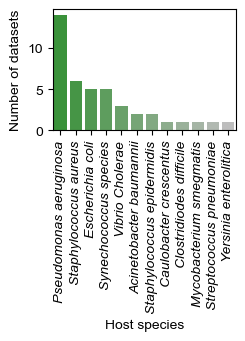

In [8]:
palette = sns.color_palette(
    "blend:#2ca02c,#bdbdbd",
    n_colors=len(df_plot)
)
ax = sns.barplot(df_plot, x="host", y="count", palette=palette)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    fontstyle="italic"
)
ax.set_xlabel("Host species")
ax.set_ylabel("Number of datasets")

plt.savefig("Datasets_by_host.svg", dpi=600, format="svg")

### Plot pie chart of phage lifestyles

In [9]:
df_plot = dataset_table.groupby("phage_type").count()[["id", "name_host"]]
df_plot.columns = ["count", "name_host"]
df_plot["phage_type"] = df_plot.index.tolist()
df_plot.sort_values("count", axis=0, ascending=False, inplace=True)
df_plot

,count,name_host,phage_type
phage_type,,,
virulent,35,35,virulent
temperate,7,7,temperate


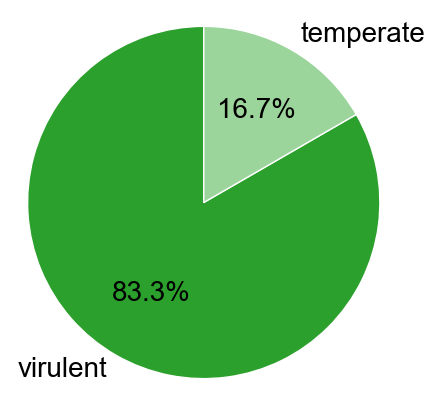

In [10]:
set_publication_style(
    width_cm=6,
    height_cm=4,
    font_size=20,
    font_family="Arial"
)

colors = ["#2ca02c", "#9bd59b"]

plt.figure(figsize=(5, 5))
plt.pie(
    df_plot["count"],
    labels=df_plot["phage_type"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white"}
)

plt.axis("equal")  # ensures a perfect circle
plt.savefig("Phage_lifestyles.svg", dpi=600, format="svg")
plt.show()

### Plot bar chart of first author_year and conribution of each dataset to hosts and phages

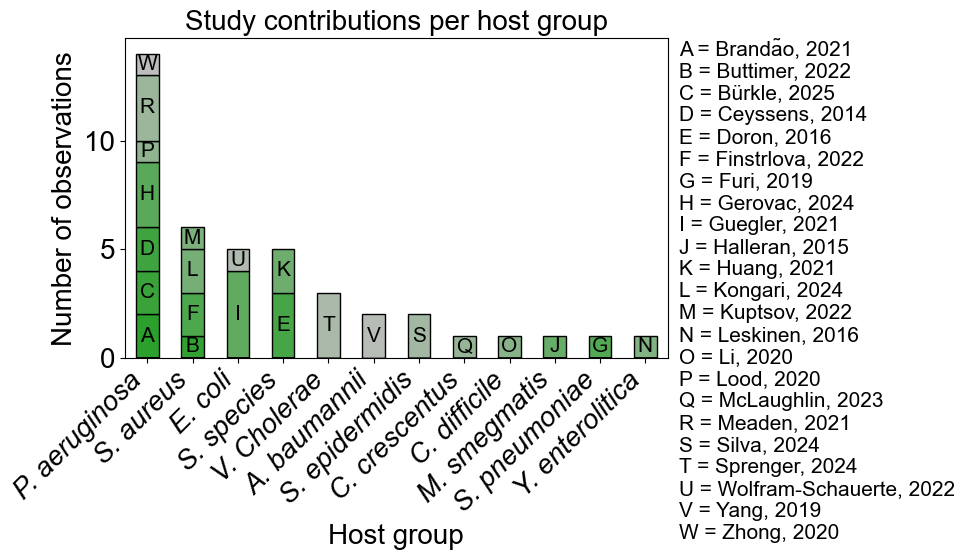

In [11]:
set_publication_style(
    width_cm=6,
    height_cm=4,
    font_size=20,
    font_family="Arial"
)

df_plot = dataset_table.copy()
df_plot["study"] = df_plot["firstauthor"].astype(str) + ", " + df_plot["year"].astype(str)

count_df_plot = (
    df_plot
    .groupby(["group", "study"])
    .size()
    .reset_index(name="count")
)

pivot_df = count_df_plot.pivot(
    index="group",
    columns="study",
    values="count"
).fillna(0)

pivot_df = pivot_df.loc[host_order,]

studies = pivot_df.columns.tolist()
labels = dict(zip(studies, string.ascii_uppercase))

palette = sns.color_palette(
    "blend:#2ca02c,#bdbdbd",
    n_colors=pivot_df.shape[1]
)

ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=palette,
    edgecolor="black",
    legend=False
)

# Annotate stacks
for i, study in enumerate(pivot_df.columns):
    bottoms = pivot_df.iloc[:, :i].sum(axis=1)
    heights = pivot_df[study]

    for x, (bottom, height) in enumerate(zip(bottoms, heights)):
        if height > 0:
            ax.text(
                x,
                bottom + height / 2,
                labels[study],
                ha="center",
                va="center",
                fontsize=15,
                color="black"
            )

ax.set_xlabel("Host group")
ax.set_ylabel("Number of observations")
ax.set_title("Study contributions per host group")

# ax.legend(
#     title="Study",
#     bbox_to_anchor=(1.05, 1),
#     loc="upper left"
# )

legend_text = "\n".join(f"{labels[k]} = {k}" for k in labels)

ax.text(
    1.02,
    1,
    legend_text,
    transform=ax.transAxes,
    fontsize=15,
    va="top"
)

def abbreviate_species(name):
    parts = name.split()
    if len(parts) >= 2:
        return f"{parts[0][0]}. {' '.join(parts[1:])}"
    return name


ax.set_xticklabels(
    [abbreviate_species(label.get_text()) for label in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    fontstyle="italic"
)

plt.tight_layout()
plt.savefig("Datasets_by_host_by_study_green.svg", dpi=600, format="svg")
plt.show()

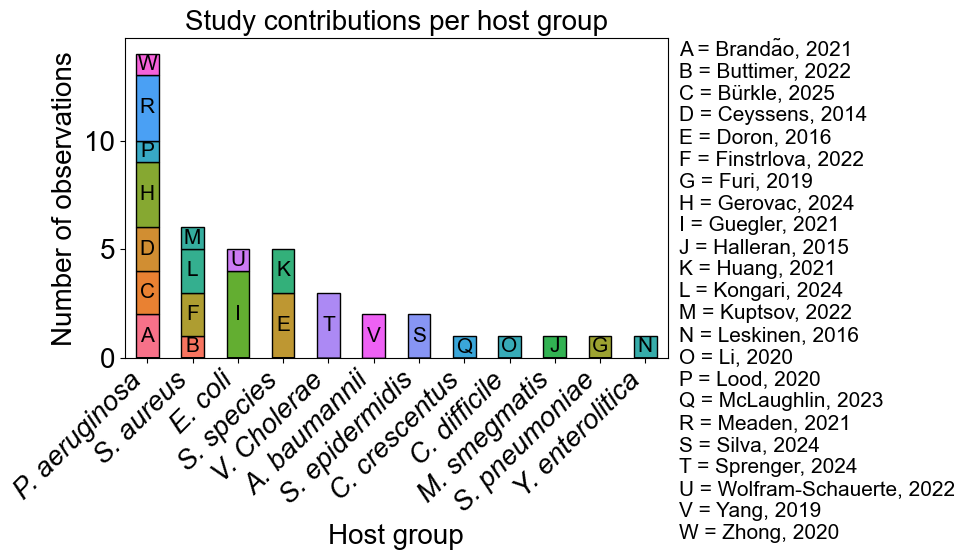

In [12]:
studies = pivot_df.columns.tolist()
labels = dict(zip(studies, string.ascii_uppercase))

palette = sns.color_palette("husl", n_colors=25)

ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=palette,
    edgecolor="black",
    legend=False
)

# Annotate stacks
for i, study in enumerate(pivot_df.columns):
    bottoms = pivot_df.iloc[:, :i].sum(axis=1)
    heights = pivot_df[study]

    for x, (bottom, height) in enumerate(zip(bottoms, heights)):
        if height > 0:
            ax.text(
                x,
                bottom + height / 2,
                labels[study],
                ha="center",
                va="center",
                fontsize=15,
                color="black"
            )

ax.set_xlabel("Host group")
ax.set_ylabel("Number of observations")
ax.set_title("Study contributions per host group")

# ax.legend(
#     title="Study",
#     bbox_to_anchor=(1.05, 1),
#     loc="upper left"
# )

legend_text = "\n".join(f"{labels[k]} = {k}" for k in labels)

ax.text(
    1.02,
    1,
    legend_text,
    transform=ax.transAxes,
    fontsize=15,
    va="top"
)

def abbreviate_species(name):
    parts = name.split()
    if len(parts) >= 2:
        return f"{parts[0][0]}. {' '.join(parts[1:])}"
    return name


ax.set_xticklabels(
    [abbreviate_species(label.get_text()) for label in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    fontstyle="italic"
)

plt.tight_layout()
plt.savefig("Datasets_by_host_by_study_colorful.svg", dpi=600, format="svg")
plt.show()

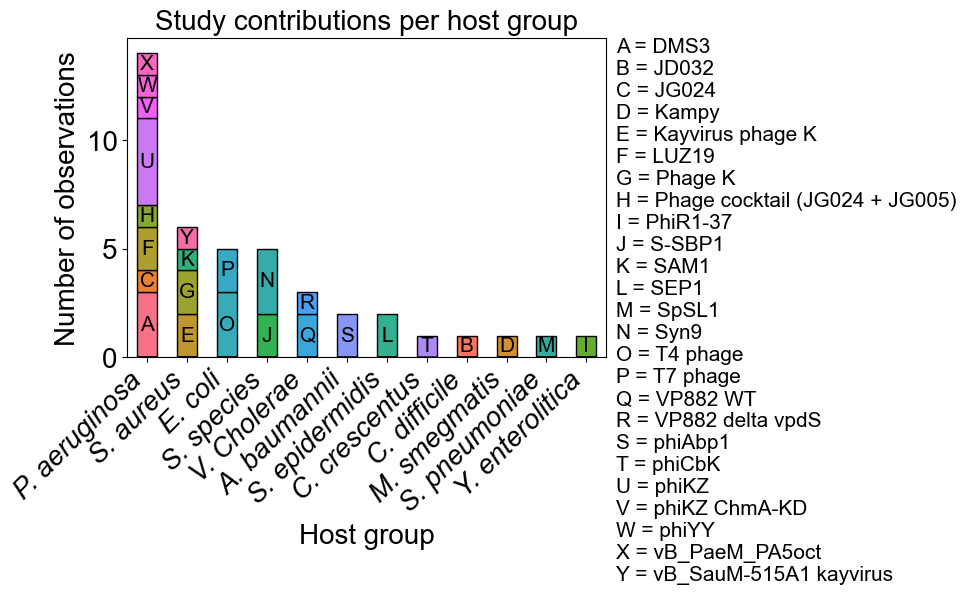

In [13]:
count_df_plot = (
    df_plot
    .groupby(["group", "name_phage"])
    .size()
    .reset_index(name="count")
)

pivot_df = count_df_plot.pivot(
    index="group",
    columns="name_phage",
    values="count"
).fillna(0)

pivot_df = pivot_df.loc[host_order,]

phages = pivot_df.columns.tolist()
labels = dict(zip(phages, string.ascii_uppercase))

palette = sns.color_palette(
    "blend:#2ca02c,#bdbdbd",
    n_colors=pivot_df.shape[1]
)

palette = sns.color_palette("husl", n_colors=25)

ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=palette,
    edgecolor="black",
    legend=False
)

# Annotate stacks
for i, phage in enumerate(pivot_df.columns):
    bottoms = pivot_df.iloc[:, :i].sum(axis=1)
    heights = pivot_df[phage]

    for x, (bottom, height) in enumerate(zip(bottoms, heights)):
        if height > 0:
            ax.text(
                x,
                bottom + height / 2,
                labels[phage],
                ha="center",
                va="center",
                fontsize=15,
                color="black"
            )

ax.set_xlabel("Host group")
ax.set_ylabel("Number of observations")
ax.set_title("Study contributions per host group")

legend_text = "\n".join(f"{labels[k]} = {k}" for k in labels)

ax.text(
    1.02,
    1,
    legend_text,
    transform=ax.transAxes,
    fontsize=15,
    va="top"
)

def abbreviate_species(name):
    parts = name.split()
    if len(parts) >= 2:
        return f"{parts[0][0]}. {' '.join(parts[1:])}"
    return name


ax.set_xticklabels(
    [abbreviate_species(label.get_text()) for label in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    fontstyle="italic"
)

plt.tight_layout()
plt.savefig("Datasets_by_host_by_phage_colorful.svg", dpi=600, format="svg")
plt.show()

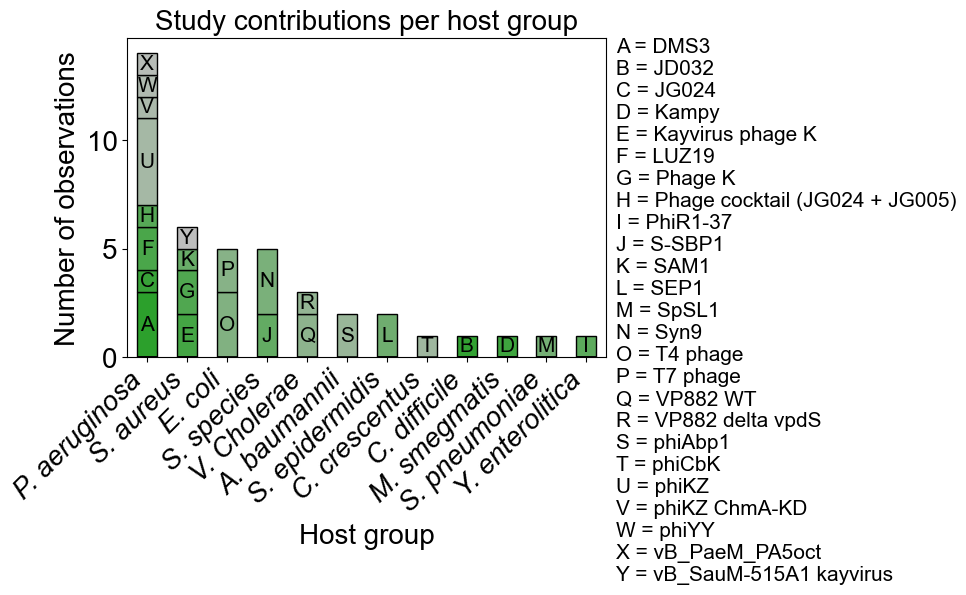

In [14]:
phages = pivot_df.columns.tolist()
labels = dict(zip(phages, string.ascii_uppercase))

palette = sns.color_palette(
    "blend:#2ca02c,#bdbdbd",
    n_colors=pivot_df.shape[1]
)

ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=palette,
    edgecolor="black",
    legend=False
)

# Annotate stacks
for i, phage in enumerate(pivot_df.columns):
    bottoms = pivot_df.iloc[:, :i].sum(axis=1)
    heights = pivot_df[phage]

    for x, (bottom, height) in enumerate(zip(bottoms, heights)):
        if height > 0:
            ax.text(
                x,
                bottom + height / 2,
                labels[phage],
                ha="center",
                va="center",
                fontsize=15,
                color="black"
            )

ax.set_xlabel("Host group")
ax.set_ylabel("Number of observations")
ax.set_title("Study contributions per host group")

legend_text = "\n".join(f"{labels[k]} = {k}" for k in labels)

ax.text(
    1.02,
    1,
    legend_text,
    transform=ax.transAxes,
    fontsize=15,
    va="top"
)

def abbreviate_species(name):
    parts = name.split()
    if len(parts) >= 2:
        return f"{parts[0][0]}. {' '.join(parts[1:])}"
    return name


ax.set_xticklabels(
    [abbreviate_species(label.get_text()) for label in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    fontstyle="italic"
)

plt.tight_layout()
plt.savefig("Datasets_by_host_by_phage_green.svg", dpi=600, format="svg")
plt.show()